# Elliptic Curves

An Elliptic Curve is of the form:
$$
y^2 = x^3 + ax + b
$$

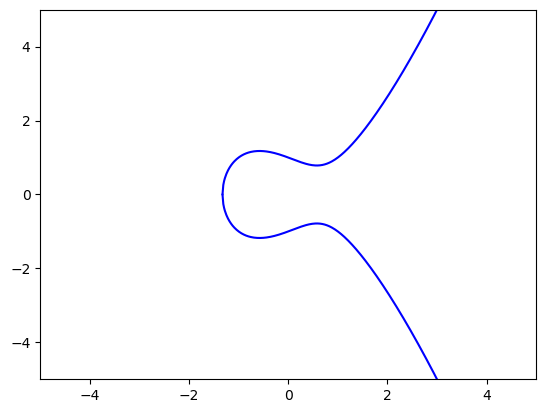

In [699]:
import numpy as np
import matplotlib.pyplot as plt
a, b = -1, 1
def curve(x):
    return x**3 + a*x + b
x = np.linspace(-1.32471, 5, 400)
y = np.sqrt(curve(x))
plt.plot(x, y, 'b-', x, -y, 'b-')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()


### Using the **double-and-add** algorithm:

Modular inverse of $A$ with respect to modulus $m$:
$$
(A \cdot A^{-1}) \pmod m = 1
$$

In [700]:
# simplify modular inverse
def minverse(A: int, p: int) -> int: return pow(A, -1, p)

#### Adding

Adding two points Q and P:
$$
Q + P = R
$$
$$
(x_q, y_q) + (x_p, y_p) = (x_r, y_p)
$$
where
$$
\begin{aligned}
\lambda &= \frac{y_q - y_p}{x_q - x_p}\\
x_r &= \lambda^2 - x_p - x_q\\
y_r &= \lambda(x_p - x_r) - y_p
\end{aligned}
$$

In [701]:
def add(Q, P, a, p):
    # if the points are the same, then double
    if Q == P:
        return double(Q, P, a, p)

    xq, yq = Q
    xp, yp = P
    if p:
        slope = ((yq - yp) * minverse((xq - xp), p)) % p
        xr = (slope**2 - xp - xq) % p
        yr = (slope*(xp - xr) - yp) % p
    else:
        slope = (yq - yp) / (xq - xp)
        xr = (slope**2 - xp - xq)
        yr = (slope*(xp - xr) - yp)

    return xr, yr

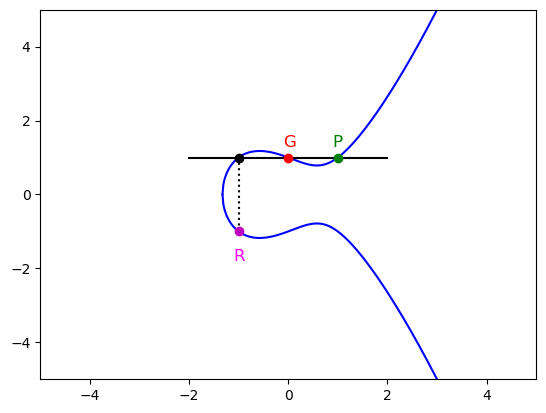

In [702]:
# simple addition example
G = (0, 1)
P = (1, 1)
R = add(G, P, 0, None)

# --------------PLOTTING-------------
x_line = np.linspace(-2, 2, 100)
y_line = np.full_like(x_line, 1)

plt.plot(x, y, 'b-', x, -y, 'b-'); plt.xlim(-5, 5); plt.ylim(-5, 5); plt.plot(x_line, y_line, 'k-')
plt.vlines(x = -1, ymin=-1, ymax=1, colors='k', linestyles='dotted'); plt.plot(*G, 'ro'); plt.plot(*P, 'go'); plt.plot(*R, 'mo'); plt.plot(*(-1, 1), 'ko')
plt.text(G[0] - 0.1, G[1] + 0.3, 'G', fontsize=12, color='red'); plt.text(P[0] - 0.1, P[1] + 0.3, 'P', fontsize=12, color='green'); plt.text(R[0] - 0.1, R[1] - 0.8, 'R', fontsize=12, color='magenta')
plt.show()
# --------------PLOTTING-------------


#### Doubling

Doubling a point is the same as adding it to itself, where the slope is the tangent to the elliptic curve:
$$
2Q = Q + Q
$$
where
$$
\lambda = \frac{3x_q^2 + a}{2y_q}
$$

In [703]:
def double(Q, a, p):
    xq, yq = Q
    if p:
        slope = (((3 * xq**2 + a) % p) * minverse((2 * yq), p)) % p
        x = (slope**2 - 2*xq) % p
        y = (slope*(xq - x) - yq) % p
    else:
        slope = (3 * xq**2 + a) / (2 * yq)
        x = (slope**2 - 2*xq)
        y = (slope*(xq - x) - yq)

    return x, y

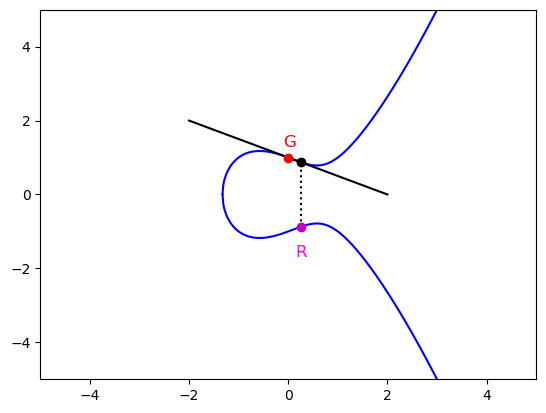

In [704]:
# simple doubling example
G = (0, 1)
R = double(G, a, None)

# --------------PLOTTING-------------
slope = (3 * G[0]**2 + a) / (2 * G[1])
x_line = np.linspace(-2, 2, 100)
y_line = slope*x_line + b

plt.plot(x, y, 'b-', x, -y, 'b-'); plt.xlim(-5, 5); plt.ylim(-5, 5); plt.plot(x_line, y_line, 'k-')
plt.vlines(x = 0.25, ymin=-0.875, ymax=0.875, colors='k', linestyles='dotted'); plt.plot(*G, 'ro'); plt.plot(*R, 'mo'); plt.plot(*(0.25, 0.875), 'ko')
plt.text(G[0] - 0.1, G[1] + 0.3, 'G', fontsize=12, color='red'); plt.text(R[0] - 0.1, R[1] - 0.8, 'R', fontsize=12, color='magenta')
plt.show()
# --------------PLOTTING-------------

#### Algorithm

The **<span style="font-size:larger;">double-and-add</span>** algorithm works to find the "public key" $Q$ that satisfies
$$
Q = nP
$$
where $n$ is the "private key" and $P$ is a known point in $O(\log_2{n})$ or $O(d)$ time where $d$ is the number of bits required to represent $n$

The algorithm works by doing the following:
1. Turn $n$ to binary representation
2. Go from most significant bit to least
3. Ignore first bit
4. Start with a double operation
5. If bit is a 0, then double
6. If bit is a 1, then double and add


In [705]:
from numpy import binary_repr

def double_and_add(n: int, P: tuple[int, int], a: int, p: int):
    bits = binary_repr(n)

    Q = P
    for bit in bits[1:]:
        Q = double(Q, a, p)
        if int(bit) == 1:
            Q = add(Q, P, a, p)
    return Q

If you want to calculate the wallet address of your private key with a 12 word seed phrase:

In [706]:
from bip_utils import Bip39SeedGenerator, Bip84, Bip84Coins, Bip44Changes

# INSERT your 12-word mnemonic (BIP39)
mnemonic = "test test test test test test test test test test test junk"
seed_bytes = Bip39SeedGenerator(mnemonic).Generate()
bip84_wallet = Bip84.FromSeed(seed_bytes, Bip84Coins.BITCOIN)
account = bip84_wallet.Purpose().Coin().Account(0).Change(Bip44Changes.CHAIN_EXT).AddressIndex(0)

private_key_int = int(account.PrivateKey().Raw().ToHex(), 16)

In [707]:
# A simple example curve to find the public key of a random number
# Using the secp256k1 curve that bitcoin uses
from random import randrange

LOW = 1
HIGH = 115792089237316195423570985008687907852837564279074904382605163141518161494337
n = randrange(LOW, HIGH)
# Uncomment below to use the seed phrase
# n = private_key_int
a = 0
b = 7
p = 115792089237316195423570985008687907853269984665640564039457584007908834671663
# generator point
G = 55066263022277343669578718895168534326250603453777594175500187360389116729240, 32670510020758816978083085130507043184471273380659243275938904335757337482424

nG = double_and_add(n, G, a, p)
x, y = nG
hx, hy = format(x, 'x'), format(y, 'x')
public_key = "04" + hx + hy

if y % 2 == 0:
    public_key_compressed = "02" + hx
else:
    public_key_compressed = "03" + hx

#print("Generator double: ", double(G, a, p))
print("Random number: ", n, "\n")
print("nG: ", nG, "")
print("nG (hex): ", f"{hx}, {hy}\n")
print("Public Key (uncompressed): ", public_key)
print("Public Key (compressed): ", public_key_compressed)

Random number:  6812922442505935591976979926729198590856277446866170017788148172946307482040 

nG:  (69420697081094909544102957323796880046042312868114822560344162945831170086828, 103715874619904019492696772534361227332092087772874538879071722303344113554375) 
nG (hex):  997ab8ddfb67fec1ee57ec07857f32b0f1a1d56c8290dfda0a732cd1f2e617ac, e54d1ad0a40726b0c3d51a80a1f1c82764e690d98ae0ea160f707f2ec41313c7

Public Key (uncompressed):  04997ab8ddfb67fec1ee57ec07857f32b0f1a1d56c8290dfda0a732cd1f2e617ace54d1ad0a40726b0c3d51a80a1f1c82764e690d98ae0ea160f707f2ec41313c7
Public Key (compressed):  03997ab8ddfb67fec1ee57ec07857f32b0f1a1d56c8290dfda0a732cd1f2e617ac


Convert public key to address:

In [708]:
import hashlib
from bech32 import encode

pub_bytes = bytes.fromhex(public_key_compressed)
sha = hashlib.sha256(pub_bytes).digest()
ripemd = hashlib.new('ripemd160', sha).digest()

hrp = "bc"
witver = 0

address = encode(hrp, witver, ripemd)
print(address)

bc1qnxsswe2wtdad99uladp7884pz8rwp32ud3lces
